In [88]:
import pandas as pd
import psycopg2
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import alpaca_trade_api as tradeapi
import numpy as np
import requests
from scipy import stats
from talib import MACD, RSI, BBANDS
from datetime import datetime, timedelta, date
from IPython.display import display, HTML
%matplotlib inline
import json
import math
from dateutil import parser
from pytz import timezone
import sys

In [89]:
start_day_to_analyze = '2020-05-01'
end_day_to_analyze = '2020-05-02'

In [90]:
db_conn = create_engine("postgresql://momentum@localhost:5432/tradedb")

In [91]:
api = tradeapi.REST(base_url="https://api.alpaca.markets")
session = requests.session()

In [92]:
query = f'''
SELECT * 
FROM 
new_trades as t
WHERE 
    tstamp >= '{start_day_to_analyze}' and 
    tstamp < '{end_day_to_analyze}' 
ORDER BY symbol, tstamp
'''
trades =  pd.read_sql_query(query, db_conn)

In [93]:
query = f'''
SELECT * 
FROM 
algo_run as t
WHERE 
    start_time >= '{start_day_to_analyze}' and 
    start_time < '{end_day_to_analyze}' 
ORDER BY algo_run_id
'''
algo_runs = pd.read_sql_query(query, db_conn)

In [94]:
trades

,trade_id,algo_run_id,symbol,operation,qty,price,indicators,client_time,tstamp,stop_price,target_price
0,2721,434,AVEO,buy,180,7.10,"{'avg': 6.8221, 'rsi': 64.63698907616617, 'mac...",2020-05-01 13:51:27.496171+00:00,2020-05-01 13:51:27.624983,6.60,8.72
1,2734,434,AVEO,sell,16,7.31,"{'avg': 6.9097, 'rsi': [66.9677913582014, 69.2...",2020-05-01 14:25:39.774057+00:00,2020-05-01 14:25:39.865552,6.60,8.72
2,2735,434,AVEO,sell,74,7.31,"{'avg': 6.9097, 'rsi': [66.9677913582014, 69.2...",2020-05-01 14:25:39.936625+00:00,2020-05-01 14:25:40.131209,6.60,8.72
3,2741,434,AVEO,sell,90,7.04,"{'avg': 6.9794, 'rsi': [44.51789102105541, 43....",2020-05-01 14:40:06.448503+00:00,2020-05-01 14:40:06.689186,6.60,8.72
4,2727,434,BSGM,buy,455,8.30,"{'avg': 8.0766, 'rsi': 69.59907817149566, 'mac...",2020-05-01 13:56:01.805415+00:00,2020-05-01 13:56:01.953785,8.09,8.93
5,2729,434,BSGM,sell,455,8.00,"{'avg': 8.1078, 'rsi': [52.50035742062962, 44....",2020-05-01 14:01:49.638753+00:00,2020-05-01 14:01:49.724198,8.09,8.93
6,2724,434,CODX,buy,127,12.59,"{'avg': 12.2613, 'rsi': 77.8959571846427, 'mac...",2020-05-01 13:55:24.920292+00:00,2020-05-01 13:55:25.163194,11.85,14.85
7,2725,434,CODX,sell,25,12.65,"{'avg': 12.269, 'rsi': [76.80803477008818, 78....",2020-05-01 13:55:40.604926+00:00,2020-05-01 13:55:40.748240,11.85,14.85
8,2726,434,CODX,sell,102,12.65,"{'avg': 12.269, 'rsi': [76.80803477008818, 78....",2020-05-01 13:55:40.635866+00:00,2020-05-01 13:55:40.826783,11.85,14.85
9,2728,434,CODX,buy,94,12.80,"{'avg': 12.4196, 'rsi': 73.0985852673536, 'mac...",2020-05-01 14:01:19.819685+00:00,2020-05-01 14:01:19.984782,11.85,15.91


In [95]:
trade_details = {}

for index, row in trades.iterrows():
    algo_run_id = row['algo_run_id']
    symbol = row['symbol']
    time = row['tstamp']
    operation = row['operation']
    price = row['price']
    indicators = row['indicators']
    qty = row['qty'] 
    stop_price = row['stop_price']
    target_price = row['target_price']
    if algo_run_id not in trade_details:
        trade_details[algo_run_id] = {}
    if symbol not in trade_details[algo_run_id]:
        trade_details[algo_run_id][symbol] = []
    trade_details[algo_run_id][symbol].append((operation, time, price, qty, indicators, stop_price, target_price))

In [96]:
runs = trades['algo_run_id'].value_counts()
revenues = {}
how_was_my_day = {}

for run_id, count in runs.items():
    symbols = trades.loc[trades['algo_run_id'] == run_id]['symbol'].value_counts()
    revenues[run_id] = []
    symbol_name = []
    counts = []
    for symbol, count in symbols.items():
        
        revnue = 0
        precentage = 0.0

        for trade in trade_details[run_id][symbol]:
            delta = trade[2] * trade[3] * (1 if trade[0] == 'sell' or trade[0] == 'buy_short' else -1)
            revnue += delta

        revenues[run_id].append(revnue)
        counts.append(count)
        symbol_name.append(symbol)


    d = {
        'symbol': symbol_name,
        'count': counts,
        'revenue': revenues[run_id],
    }
    how_was_my_day[run_id] = pd.DataFrame(data=d)

In [97]:
for algo_id, how_did_i_do in how_was_my_day.items():
    display(HTML(algo_runs.loc[algo_runs['algo_run_id'] == algo_id].to_html()))
    display(HTML(how_did_i_do.round(2).sort_values(by=['revenue']).to_html()))
    print(f'TOTAL REVENUE: {pd.Series(revenues[algo_id]).sum().round(2)} $')


,algo_run_id,algo_name,algo_env,build_number,parameters,start_time,end_time,end_reason
0,434,momentum_long,PAPER,v0.1-355-gf28ef51,"{'DSN': 'postgresql://momentum@10.63.80.3/tradedb', 'TRADE_BUY_WINDOW': 90}",2020-05-01 13:45:01.530141,None,None


,symbol,count,revenue
7,BSGM,2,-136.50
5,LIND,3,-106.80
6,MIST,2,-51.45
2,HOME,4,8.85
3,AVEO,4,13.50
1,CODX,6,41.93
4,DRIP,3,59.40
0,FRTA,6,92.70


TOTAL REVENUE: -78.37 $


In [98]:

minute_history = {}
minute_history1 = {}
for run_id, count in runs.items():
    symbols = trades.loc[trades['algo_run_id'] == run_id]['symbol'].value_counts()
    for symbol, count in symbols.items():
        if symbol not in minute_history:
            minute_history[symbol] = api.polygon.historic_agg_v2(
                symbol, 
                1, 
                'minute',
                _from = (datetime.strptime(start_day_to_analyze, '%Y-%m-%d')-timedelta(days=10)).date(),
                to=(datetime.strptime(end_day_to_analyze, '%Y-%m-%d')+timedelta(days=1)).date()).df
            minute_history1[symbol] = api.polygon.historic_agg_v2(
                symbol, 
                1, 
                'minute',
                _from = (datetime.strptime(start_day_to_analyze, '%Y-%m-%d')-timedelta(days=20)).date(),
                to=(datetime.strptime(end_day_to_analyze, '%Y-%m-%d')-timedelta(days=11)).date()).df

In [ ]:
minute_history['GLOP']

In [ ]:
minute_history1['GLOP']

In [ ]:
m = minute_history1['GLOP'].append(minute_history['GLOP'])

In [ ]:
m[:3976]

In [ ]:
RSI(m[:3976]['close'].dropna().between_time("9:30", "16:00"))

In [99]:
def grouper(iterable):
    prev = None
    group = []
    for item in iterable:
        
        if not prev or -0.02 <= float(item - prev) / prev <= 0.02:
            group.append(item)
        else:
            yield group
            group = [item]
        prev = item
    if group:
        yield group

def find_resistance(current_value, minute_history, now):
    """calculate next resistance"""
    now = pd.Timestamp(now) - timedelta(hours=4)
    print(f"now={now}")
    
    #print(minute_history)
    minute_history_index = minute_history["close"].index.get_loc(now, method='nearest')
    #print(f'index:{minute_history_index} data:{minute_history["close"][minute_history_index]}')
    for back_track_min in range(200, len(minute_history.index), 60):
        #print("start")
        series = (
            minute_history["close"][-back_track_min:minute_history_index].dropna().resample("5min").max()
        ).dropna()
        #print(series[0:10])
        # tlog(f"{symbol} find_resistances(): {len(series)}")

        diff = np.diff(series.values)
        #print(diff)
        high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
        #print(high_index)
        if len(high_index) > 0:
            local_maximas = sorted(
                [series[i] for i in high_index if series[i] >= current_value]
            )
            #print(f"local_maximas={local_maximas}")
            if len(local_maximas) > 0:
                return local_maximas
            continue
            
            clusters = dict(enumerate(grouper(local_maximas), 1))
            #print(f"cluster={clusters}")
            resistances = []
            for key, cluster in clusters.items():
                if len(cluster) > 1:
                    resistances.append(round(sum(cluster) / len(cluster), 2))
            resistances = sorted(resistances)

            if len(resistances) > 0:
                return resistances


    return None

def find_support(current_value, minute_history, now):
    """calculate support"""
    now = pd.Timestamp(now) - timedelta(hours=4)
    minute_history_index = minute_history["close"].index.get_loc(now, method='nearest')
    for back_track_min in range(200, len(minute_history.index), 60):
        series = (minute_history["close"][-back_track_min:minute_history_index].resample("5min").min()).dropna()
        diff = np.diff(series.values)
        high_index = np.where((diff[:-1] <= 0) & (diff[1:] > 0))[0] + 1
        if len(high_index) > 0:
            local_maximas = sorted(
                [series[i] for i in high_index if series[i] <= current_value]
            )
            if len(local_maximas) > 0:
                return local_maximas
            
    return None

now=2020-05-01 09:48:03.349029
now=2020-05-01 10:19:42.521186
FRTA analysis for run 434 with profit 92.7


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-811.3,-811.3,buy,2020-05-01 13:48:03.349029,8.54,"[7.72, 7.72, 7.995]","[8.9, 8.99, 9.05, 9.05]",95,"{'avg': 8.1195, 'rsi': 71.34914065060586, 'macd': [0.02791067590369778, 0.05514940693535664, 0.07346864740819115, 0.0925681247312582, 0.1088623804717681], 'vwap': 8.5594, 'supports': [7.72, 7.995, 8.02, 8.0201, 8.14], 'sell_macd': [0.01941727341974442, 0.03703347210260688, 0.04872098442558226, 0.06083176046393213, 0.07103195269558071], 'slow macd': [-0.0025030637806491285, 0.003918783265174142, 0.009341012341293364, 0.015434249068517758, 0.021493745555151378], 'macd_signal': [-0.017813906761555223, -0.0032212440221728485, 0.012116734263899951, 0.0282070123573716, 0.0443380859802509], 'resistances': [8.9, 8.99, 9.05, 9.05], 'sell_macd_signal': [-0.010997773177825661, -0.0013915241217391534, 0.008630977587725129, 0.01907113416296653, 0.029463297869489365]}",11.56,7.56
1,-397.7,413.6,sell,2020-05-01 13:50:10.513575,8.80,None,None,47,"{'avg': 8.2379, 'rsi': [72.31857138104925, 77.13892325979546], 'vwap': 8.7311, 'reasons': 'scale-out', 'movement': 0.025761124121779937, 'sell_macd': [0.04872098442558226, 0.06083176046393213, 0.0715566280202573, 0.08002332185609262, 0.09441265053523651], 'sell_macd_signal': [0.008630977587725129, 0.01907113416296653, 0.029568232934424683, 0.03965925071875827, 0.05060993068205392]}",11.56,7.56
2,24.7,422.4,sell,2020-05-01 13:50:19.507122,8.80,None,None,48,"{'avg': 8.2705, 'rsi': [76.53810316373215, 78.14627093659769], 'vwap': 8.8016, 'reasons': 'rsi max, cool-down for 5 minutes', 'movement': 0.0, 'sell_macd': [0.06083176046393213, 0.0715566280202573, 0.08002332185609262, 0.0931139492365336, 0.10548178941302666], 'sell_macd_signal': [0.01907113416296653, 0.029568232934424683, 0.03965925071875827, 0.05035019042231333, 0.061376510220455996]}",11.56,7.56
3,-3455.3,-3480.0,buy,2020-05-01 14:19:42.521186,8.70,"[7.72, 7.72, 7.995, 8.4901]",[8.79],400,"{'avg': 8.4856, 'rsi': 60.02772474858996, 'macd': [0.02271462040897454, 0.03381089154321337, 0.04278932742851893, 0.04375204127109811, 0.04652850321305024], 'vwap': 8.7085, 'supports': [7.72, 7.995, 8.02, 8.0201, 8.4901], 'sell_macd': [0.008414259594438533, 0.01593031186585847, 0.02201645244273287, 0.022836608055326835, 0.02482066946702055], 'slow macd': [0.06975642195422616, 0.07125912779135568, 0.07266204247351027, 0.07271700389443936, 0.07315666731466486], 'macd_signal': [0.042156286903852036, 0.040487207831724305, 0.04094763175108323, 0.041508513655086204, 0.04251251156667901], 'resistances': [8.79], 'sell_macd_signal': [0.020381572166142004, 0.019491320106085296, 0.01999634657341481, 0.020564398869797215, 0.021415652989241883]}",9.43,8.47
4,-1681.3,1774.0,sell,2020-05-01 14:31:13.450674,8.87,None,None,200,"{'avg': 8.5207, 'rsi': [63.25495324498201, 67.19621434364335], 'vwap': 8.875, 'reasons': 'scale-out', 'movement': 0.020114942528735715, 'sell_macd': [0.04132953210607404, 0.041834142728308876, 0.04142430499591754, 0.040826713191508546, 0.042687983042728916], 'sell_macd_signal': [0.03137005264413834, 0.03346287066097245, 0.03505515752796147, 0.03620946866067089, 0.03750517153708249]}",9.43,8.47
5,92.7,1774.0,sell,2020-05-01 14:36:10.971412,8.87,None,None,200,"{'avg': 8.5304, 'rsi': [64.0829299095026, 64.96814184579438], 'vwap': 8.8795, 'reasons': 'bail', 'movement': 0.001071025930101573, 'sell_macd': [0.045860738271890966, 0.04618238447688938, 0.04427999990316245, 0.04222255737943925, 0.040559322200181214], 'sell_macd_signal': [0.04029158881888157, 0.04146974795048313, 0.04203179834101899, 0.042069950148703045, 0.041767824558998676]}",9.43,8.47


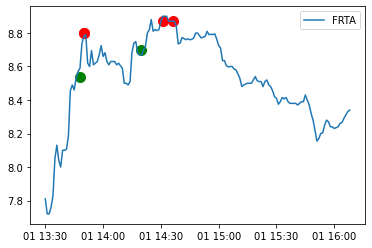

now=2020-05-01 09:55:25.163194
now=2020-05-01 10:01:19.984782
CODX analysis for run 434 with profit 41.93


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-1598.93,-1598.93,buy,2020-05-01 13:55:25.163194,12.59,"[11.91, 12.15, 12.2, 12.28]","[12.6, 12.66, 12.79, 13.75]",127,"{'avg': 12.2613, 'rsi': 77.8959571846427, 'macd': [0.11930748890967102, 0.1303650476060234, 0.13747891783700084, 0.1586128171024459, 0.1770326775856006], 'vwap': 12.5887, 'supports': [11.91], 'sell_macd': [0.06675963492293491, 0.07399193827030537, 0.07862500661539684, 0.09236733251267104, 0.10426567304934231], 'slow macd': [0.11439481364224591, 0.11836302656502617, 0.12181180938352298, 0.12822380539624945, 0.13465367648929139], 'macd_signal': [0.13735698183041453, 0.1359585949855363, 0.13626265955582922, 0.14073269106515257, 0.14799268836924218], 'resistances': [12.7007, 12.77, 12.77, 12.84, 12.8599], 'sell_macd_signal': [0.079268453438025, 0.07821315040448107, 0.07829552164666423, 0.08110988381986559, 0.08574104166576094]}",14.85,11.85
1,-1282.68,316.25,sell,2020-05-01 13:55:40.748240,12.65,None,None,25,"{'avg': 12.269, 'rsi': [76.80803477008818, 78.96833119534395], 'vwap': 12.5998, 'reasons': 'rsi max, cool-down for 5 minutes', 'movement': 0.004765687053216878, 'sell_macd': [0.06675963492293491, 0.07399193827030537, 0.07862500661539684, 0.09236733251267104, 0.10686307564674635], 'sell_macd_signal': [0.079268453438025, 0.07821315040448107, 0.07829552164666423, 0.08110988381986559, 0.08626052218524174]}",14.85,11.85
2,7.62,1290.30,sell,2020-05-01 13:55:40.826783,12.65,None,None,102,"{'avg': 12.269, 'rsi': [76.80803477008818, 78.96833119534395], 'vwap': 12.5998, 'reasons': 'rsi max, cool-down for 5 minutes', 'movement': 0.004765687053216878, 'sell_macd': [0.06675963492293491, 0.07399193827030537, 0.07862500661539684, 0.09236733251267104, 0.10686307564674635], 'sell_macd_signal': [0.079268453438025, 0.07821315040448107, 0.07829552164666423, 0.08110988381986559, 0.08626052218524174]}",14.85,11.85
3,-1195.58,-1203.20,buy,2020-05-01 14:01:19.984782,12.80,"[11.91, 12.15, 12.2, 12.28]",[12.98],94,"{'avg': 12.4196, 'rsi': 73.0985852673536, 'macd': [0.221606244174124, 0.23205620418085715, 0.25513288277096713, 0.25985526191967345, 0.26187017137328006], 'vwap': 12.8557, 'supports': [11.91], 'sell_macd': [0.13277185775520017, 0.13923438382747477, 0.15388006149642308, 0.15648864069954627, 0.157320148640947], 'slow macd': [0.15134914168630154, 0.1577978872404202, 0.16699395760070423, 0.17309239105476593, 0.17868220545443592], 'macd_signal': [0.1746417661866595, 0.18612465378549903, 0.19992629958259264, 0.2119120920500088, 0.22190370791466305], 'resistances': [12.98], 'sell_macd_signal': [0.10281696142749437, 0.11010044590749045, 0.11885636902527698, 0.12638282336013085, 0.1325702884162941]}",15.91,11.85
4,-580.82,614.76,sell,2020-05-01 14:06:14.433968,13.08,None,None,47,"{'avg': 12.4706, 'rsi': [72.18291285428145, 74.5166412054612], 'vwap': 13.0151, 'reasons': 'scale-out', 'movement': 0.02187499999999995, 'sell_macd': [0.15228778487705874, 0.14618340302098076, 0.147076308028959, 0.14817368455427982, 0.15230444957980005], 'sell_macd_signal': [0.13591700848766747, 0.13797028739433012, 0.1397914915212559, 0.14146793012786069, 0.14363523401824857]}",15.91,11.85
5,41.93,622.75,sell,2020-05-01 14:09:08.103551,13.25,None,None,47,"{'avg': 12.5507, 'rsi': [77.45582911789913, 78.27050902354101], 'vwap': 13.251, 'reasons': 'rsi max, cool-down for 5 minutes', 'movement': 0.014525993883792011, 'sell_macd': [0.14817368455427982, 0.1580187352940854, 0.16363281723037382, 0.16793946786604863, 0.17121816358389808], 'sell_macd_signal': [0.14146793012786069, 0.14477809116110563, 0.14854903637495925, 0.15242712267317712, 0.15618533085532132]}",15.91,11.85


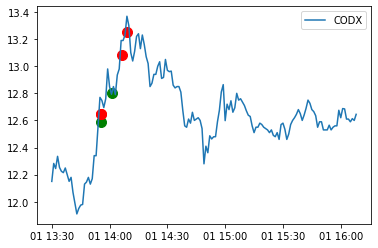

now=2020-05-01 09:47:35.172445
HOME analysis for run 434 with profit 8.85


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-888.54,-888.54,buy,2020-05-01 13:47:35.172445,2.51,"[2.25, 2.27, 2.28, 2.3, 2.3, 2.3, 2.35, 2.4098, 2.4099]","[2.5781, 2.67]",354,"{'avg': 2.4063, 'rsi': 64.44314436017531, 'macd': [0.019178033298253183, 0.021260494160093124, 0.02107825701013777, 0.0226736181375502, 0.025659458130394164], 'vwap': 2.51, 'supports': [2.28, 2.3601, 2.41], 'sell_macd': [0.012553377656878695, 0.013805171153533191, 0.013577930096984492, 0.014512834077634817, 0.016351553619990966], 'slow macd': [-0.00010545014709650857, 0.0009911444525925184, 0.00168338739384577, 0.002714222043285197, 0.004058121939401804], 'macd_signal': [0.01249425122971702, 0.01424749981579224, 0.015613651254661345, 0.017025644631239116, 0.018752407331070125], 'resistances': [2.5781, 2.67], 'sell_macd_signal': [0.008515344057332497, 0.009573309476572636, 0.010374233600655007, 0.01120195369605097, 0.01223187368083897]}",3.32,2.24
1,-433.65,454.89,sell,2020-05-01 13:48:31.745495,2.57,None,None,177,"{'avg': 2.4084, 'rsi': [65.34546410480505, 70.98233711501976], 'vwap': 2.5692, 'reasons': 'scale-out', 'movement': 0.023904382470119546, 'sell_macd': [0.013805171153533191, 0.013577930096984492, 0.014512834077634817, 0.01673596920440623, 0.020983399573261785], 'sell_macd_signal': [0.009573309476572636, 0.010374233600655007, 0.01120195369605097, 0.012308756797722021, 0.014043685352829974]}",3.32,2.24
2,-258.65,175.00,sell,2020-05-01 14:26:08.716379,2.50,None,None,70,"{'avg': 2.4774, 'rsi': [48.303657152357324, 46.41261882753553], 'vwap': 2.5001, 'reasons': 'below cost & macd negative & RSI trending down', 'movement': -0.027198443579766394, 'sell_macd': [0.0015849880084721768, 0.0011213942367933605, 0.000745588775266981, 0.0002300833666066815, -0.00047589595659092154], 'sell_macd_signal': [0.003694802416184465, 0.003180120780306244, 0.0026932143792983915, 0.0022005881767600496, 0.0016652913500898553]}",3.32,2.24
3,8.85,267.50,sell,2020-05-01 14:26:08.785133,2.50,None,None,107,"{'avg': 2.4774, 'rsi': [48.303657152357324, 46.41261882753553], 'vwap': 2.5001, 'reasons': 'below cost & macd negative & RSI trending down', 'movement': -0.027198443579766394, 'sell_macd': [0.0015849880084721768, 0.0011213942367933605, 0.000745588775266981, 0.0002300833666066815, -0.00047589595659092154], 'sell_macd_signal': [0.003694802416184465, 0.003180120780306244, 0.0026932143792983915, 0.0022005881767600496, 0.0016652913500898553]}",3.32,2.24


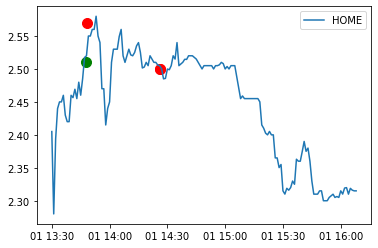

now=2020-05-01 09:51:27.624983
AVEO analysis for run 434 with profit 13.5


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-1278.00,-1278.00,buy,2020-05-01 13:51:27.624983,7.10,"[6.15, 6.2114, 6.25, 6.25, 6.3, 6.32, 6.65, 6.65, 6.6809]",[7.1963],180,"{'avg': 6.8221, 'rsi': 64.63698907616617, 'macd': [0.09271631552594695, 0.10837323065524629, 0.12708707321346946, 0.1302254162637757, 0.13591471163066782], 'vwap': 7.0696, 'supports': [6.26, 6.4, 6.45, 6.5, 6.6809], 'sell_macd': [0.05607707647541993, 0.06608126606209641, 0.07802113760934937, 0.07975063313176278, 0.08313269934232181], 'slow macd': [0.06438425918663881, 0.0692777348455964, 0.07520927285114531, 0.07852619882450185, 0.0823975070489702], 'macd_signal': [0.07480868889987542, 0.0815215972509496, 0.09063469244345357, 0.098552837207518, 0.10602521209214796], 'resistances': [7.1963], 'sell_macd_signal': [0.04496400112126292, 0.04918745410942962, 0.054954190809413564, 0.05991347927388341, 0.06455732328757109]}",8.72,6.6
1,-1161.04,116.96,sell,2020-05-01 14:25:39.865552,7.31,None,None,16,"{'avg': 6.9097, 'rsi': [66.9677913582014, 69.26969115892079], 'vwap': 7.2632, 'reasons': 'scale-out', 'movement': 0.023070422535211292, 'sell_macd': [0.009619813206127148, 0.011582178997746162, 0.014981656510725472, 0.024926942150569786, 0.034981360283557805], 'sell_macd_signal': [0.015441471272552573, 0.01466961281759129, 0.014732021556218127, 0.01677100567508846, 0.020413076596782327]}",8.72,6.6
2,-620.10,540.94,sell,2020-05-01 14:25:40.131209,7.31,None,None,74,"{'avg': 6.9097, 'rsi': [66.9677913582014, 69.26969115892079], 'vwap': 7.2632, 'reasons': 'scale-out', 'movement': 0.023070422535211292, 'sell_macd': [0.009619813206127148, 0.011582178997746162, 0.014981656510725472, 0.024926942150569786, 0.034981360283557805], 'sell_macd_signal': [0.015441471272552573, 0.01466961281759129, 0.014732021556218127, 0.01677100567508846, 0.020413076596782327]}",8.72,6.6
3,13.50,633.60,sell,2020-05-01 14:40:06.689186,7.04,None,None,90,"{'avg': 6.9794, 'rsi': [44.51789102105541, 43.19957014226055], 'vwap': 7.0229, 'reasons': 'below cost & macd negative & RSI trending down', 'movement': -0.039671682626538994, 'sell_macd': [0.024909659336659118, 0.020317526047105794, 0.013077973794893616, 0.006233154198430846, -0.00022557735983141924], 'sell_macd_signal': [0.038926628536371036, 0.035204808038517985, 0.03077944118979311, 0.025870183791520656, 0.02065103156125024]}",8.72,6.6


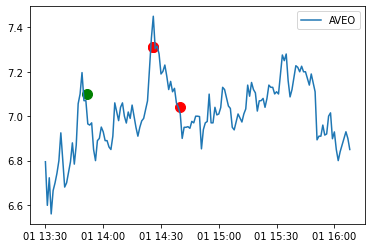

now=2020-05-01 09:50:53.116751
DRIP analysis for run 434 with profit 59.4


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-2471.7,-2471.7,buy,2020-05-01 13:50:53.116751,7.49,"[7.235, 7.36, 7.36]",[7.5],330,"{'avg': 7.4036, 'rsi': 69.89724937563939, 'macd': [0.10877633928256092, 0.10589478498230598, 0.10402582038829067, 0.10536465644268578, 0.10680830683923226], 'vwap': 7.495, 'supports': [7.235], 'sell_macd': [0.06658774030057302, 0.0644003531298658, 0.06289848841074441, 0.06350874332557588, 0.06419843880043707], 'slow macd': [0.0499136740197752, 0.05207974331794585, 0.054309174138344574, 0.05707314199967417, 0.05984467237989044], 'macd_signal': [0.09435281977788736, 0.09666121281877108, 0.098134134332675, 0.09958023875467716, 0.10102585237158818], 'resistances': [7.5623], 'sell_macd_signal': [0.058427365399070785, 0.05962196294522979, 0.060277268038332714, 0.06092356309578135, 0.06157853823671249]}",8.37,7.21
1,-1211.1,1260.6,sell,2020-05-01 13:54:01.352689,7.64,None,None,165,"{'avg': 7.4358, 'rsi': [71.71638494675031, 75.89148384575569], 'vwap': 7.64, 'reasons': 'scale-out', 'movement': 0.020026702269692852, 'sell_macd': [0.06350874332557588, 0.06315947776147546, 0.0662229139743653, 0.06723048876396298, 0.07181781342126037], 'sell_macd_signal': [0.06092356309578135, 0.06137074602892017, 0.062341179618009196, 0.06331904144719995, 0.06501879584201203]}",8.37,7.21
2,59.4,1270.5,sell,2020-05-01 13:54:38.448488,7.70,None,None,165,"{'avg': 7.4537, 'rsi': [75.18742780159738, 78.06983613381182], 'vwap': 7.695, 'reasons': 'rsi max, cool-down for 5 minutes', 'movement': 0.007198952879581231, 'sell_macd': [0.06315947776147546, 0.0662229139743653, 0.06723048876396298, 0.07091911212255919, 0.07662818081597766], 'sell_macd_signal': [0.06137074602892017, 0.062341179618009196, 0.06331904144719995, 0.06483905558227179, 0.06719688062901297]}",8.37,7.21


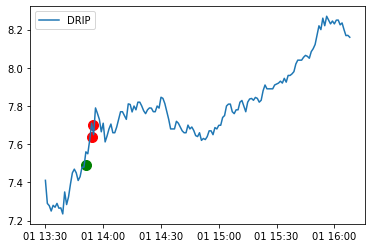

now=2020-05-01 09:50:07.468661
LIND analysis for run 434 with profit -106.8


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-1906.38,-1906.38,buy,2020-05-01 13:50:07.468661,7.14,"[6.06, 6.67, 6.72, 6.73, 6.78]",None,267,"{'avg': 6.5874, 'rsi': 64.57250846474764, 'macd': [0.1132410133660855, 0.13192943336493457, 0.1411191705906445, 0.14471660949294485, 0.14588592362445674], 'vwap': 7.1525, 'supports': [6.06, 6.67, 6.72, 6.73, 6.7454, 6.76, 6.78], 'sell_macd': [0.0751031055937963, 0.0866732364662317, 0.09199186784129587, 0.09364285504470526, 0.09371319760522301], 'slow macd': [0.01261310369364832, 0.019895220739489794, 0.025771498404233206, 0.030736803847238647, 0.0352558844585813], 'macd_signal': [0.04758939386020945, 0.06445740176115447, 0.07978975552705247, 0.09277512632023095, 0.10339728578107611], 'resistances': [7.2395], 'sell_macd_signal': [0.03331683426962475, 0.04398811470894614, 0.05358886533541608, 0.06159966327727392, 0.06802237014286373]}",8.24,6.81
1,-915.60,990.78,sell,2020-05-01 13:51:24.442875,6.74,None,None,147,"{'avg': 6.6123, 'rsi': [50.9329715118787, 46.33376610249692], 'vwap': 6.8063, 'reasons': 'stopped', 'movement': -0.051820728291316544, 'sell_macd': [0.0866732364662317, 0.09199186784129587, 0.09364285504470526, 0.07942748331950877, 0.0610852782957263], 'sell_macd_signal': [0.04398811470894614, 0.05358886533541608, 0.06159966327727392, 0.06516522728572088, 0.06434923748772196]}",8.24,6.81
2,-106.80,808.80,sell,2020-05-01 13:51:24.667902,6.74,None,None,120,"{'avg': 6.6123, 'rsi': [50.9329715118787, 46.33376610249692], 'vwap': 6.8063, 'reasons': 'stopped', 'movement': -0.051820728291316544, 'sell_macd': [0.0866732364662317, 0.09199186784129587, 0.09364285504470526, 0.07942748331950877, 0.0610852782957263], 'sell_macd_signal': [0.04398811470894614, 0.05358886533541608, 0.06159966327727392, 0.06516522728572088, 0.06434923748772196]}",8.24,6.81


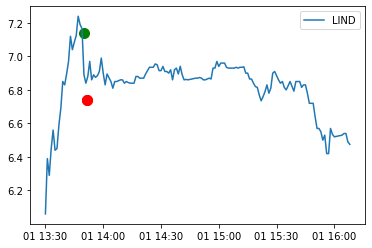

now=2020-05-01 10:16:12.286261
MIST analysis for run 434 with profit -51.45


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-435.75,-435.75,buy,2020-05-01 14:16:12.286261,4.15,"[2.86, 2.89, 2.8928, 2.9, 2.91, 2.95]",[4.27],105,"{'avg': 3.6863, 'rsi': 68.47341198605383, 'macd': [0.1944426869252065, 0.2221641958826317, 0.21981307958565566, 0.22822160009844472, 0.2318576591885395], 'vwap': 4.1431, 'supports': [2.83, 2.84, 3.0201], 'sell_macd': [0.11905906017143675, 0.1366296795025459, 0.13452068574103926, 0.13943678559257888, 0.14122807397569348], 'slow macd': [0.11404919390321666, 0.1237766202134809, 0.12820992747420235, 0.1346410351499414, 0.14027214855309067], 'macd_signal': [0.1473870542683175, 0.16234248259118034, 0.1738366019900754, 0.18471360161174927, 0.1941424131271073], 'resistances': [4.27], 'sell_macd_signal': [0.08960730496747962, 0.09901177987449288, 0.10611356104780215, 0.1127782059567575, 0.1184681795605447]}",6.87,3.25
1,-51.45,384.30,sell,2020-05-01 14:34:05.629879,3.66,None,None,105,"{'avg': 3.7382, 'rsi': [46.52269423429113, 45.22300472351137], 'vwap': 3.6742, 'reasons': 'below cost & macd negative & RSI trending down', 'movement': -0.12048192771084347, 'sell_macd': [0.03186598531518303, 0.02786485654942794, 0.0161462515819637, 0.0079532314569013, -0.0002225404776527995], 'sell_macd_signal': [0.04730137704097538, 0.043414072942665895, 0.03796050867052546, 0.03195905322780063, 0.02552273448670994]}",6.87,3.25


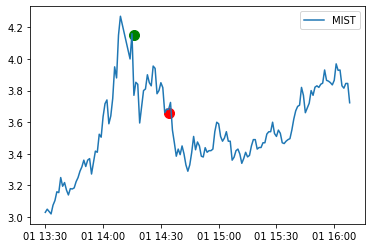

now=2020-05-01 09:56:01.953785
BSGM analysis for run 434 with profit -136.5


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-3776.5,-3776.5,buy,2020-05-01 13:56:01.953785,8.3,"[7.5829, 7.7, 7.72, 7.72, 7.7502, 7.7529, 7.8501]","[8.41, 8.4329, 8.4639, 8.47, 8.47, 8.47]",455,"{'avg': 8.0766, 'rsi': 69.59907817149566, 'macd': [0.08784342812518275, 0.08703064363727364, 0.09178381084888443, 0.09299402663178213, 0.09594568826645578], 'vwap': 8.2697, 'supports': [7.5829, 7.71, 7.75, 7.7502, 7.7529, 7.8101], 'sell_macd': [0.05275393088748537, 0.05203048386464637, 0.05494688249795843, 0.05554996088108588, 0.05729326922013023], 'slow macd': [0.048963218040007916, 0.05084864214615248, 0.05378145554065572, 0.05609943946652152, 0.058756489948549095], 'macd_signal': [0.08340953728770165, 0.08413375855761604, 0.08566376901586972, 0.0871298205390522, 0.08889299408453291], 'resistances': [8.41, 8.47], 'sell_macd_signal': [0.05078247675975602, 0.05103207818073409, 0.05181503904417896, 0.05256202341156034, 0.05350827257327432]}",8.93,8.09
1,-136.5,3640.0,sell,2020-05-01 14:01:49.724198,8.0,None,None,455,"{'avg': 8.1078, 'rsi': [52.50035742062962, 44.585821435866954], 'vwap': 8.0823, 'reasons': 'stopped', 'movement': -0.03012048192771084, 'sell_macd': [0.053046672779368365, 0.04384070495550496, 0.03870046113229364, 0.03314831709950283, 0.023196668280450083], 'sell_macd_signal': [0.05370426424655643, 0.05173155238834613, 0.049125334137135636, 0.045929930729609075, 0.04138327823977728]}",8.93,8.09


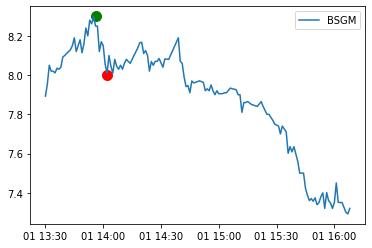

In [100]:
for run_id, count in runs.items():
    for symbol in minute_history:    
        if symbol not in trade_details[run_id]:
            continue
        start_date = datetime.strptime(start_day_to_analyze, "%Y-%m-%d") + timedelta(hours=9, minutes=30)
        minute_history_index = minute_history[symbol]["close"].index.get_loc(start_date, method='nearest')
        plt.plot(minute_history[symbol]["close"][minute_history_index:], label=symbol)

        delta = 0
        profit = 0
        
        operations = []
        deltas = []
        profits = []
        times = []
        prices = []
        qtys = []
        indicators = []
        target_price = []
        stop_price = []
        resistances = []
        supports = []
        for trade in trade_details[run_id][symbol]:
            resistance = None
            support = None
            if trade[0] == 'buy':
                resistance = find_resistance(trade[2], minute_history[symbol], trade[1])
                support = find_support(trade[2], minute_history[symbol], trade[1])
                
            delta = trade[2] * trade[3] * (1 if trade[0] == 'sell' or trade[0] == 'buy_short' else -1)
            profit += delta
            plt.scatter(pd.to_datetime(trade[1]), trade[2], c='g' if trade[0] == 'buy' or trade[0] == 'sell_short' else 'r', s=100)
            deltas.append(round(delta, 2))
            profits.append(round(profit, 2))
            operations.append(trade[0])
            times.append(pd.to_datetime(trade[1]))
            prices.append(trade[2])
            qtys.append(trade[3])
            indicators.append(trade[4])
            target_price.append(trade[6])
            stop_price.append(trade[5])    
            resistances.append(resistance)
            supports.append(support)
        d = {
            'profit': profits,
            'trade': deltas,
            'operation': operations,
            'at': times,
            'price': prices,
            'support': supports,
            'resistance': resistances,
            'qty': qtys,
            'indicators': indicators,
            'target price': target_price,
            'stop price': stop_price
        }   
        print (f'{symbol} analysis for run {run_id} with profit {round(profit, 2)}')
        display(HTML(pd.DataFrame(data=d).to_html()))
        plt.legend()
        plt.show()

In [ ]:
 pd.Timestamp('2020-04-16 13:44:06.066') 

In [ ]:
index = minute_history['NURO'].index.get_loc(pd.Timestamp('2020-04-16 13:44:06.066') , method='nearest')

In [ ]:
minute_history['NURO'][:index]

In [ ]:
series = minute_history['NURO'][:2417]['close']

In [ ]:
MACD(series.dropna().between_time("9:30", "16:00"))